# Training + Interpretation of ADHunter models on simulated data

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)

Global seed set to 0


0

In [2]:
def get_inputs(seqs:np.array, activity:np.array, threshold, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    # get binary labels based on threshold
    y_bin = (activity >= threshold).astype(np.int64).reshape(-1, 1)
    # scale data to have mean 0 and variance 1
    y_cont = activity.reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(y_cont)
    y_cont = scaler.transform(y_cont)
    # convert seqs to integer valued vectors
    aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
    i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
    X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])
    return X, y_cont, y_bin, scaler

fn = "../data/OrthologTilingDFwActivities_20240930.csv"

df = pd.read_csv(fn)
df["Activity"] = df["Activity"].fillna(0.0)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# 
df = df.dropna(subset=df.columns[:-1], axis=0)


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
alphabet="ACDEFGHIKLMNPQRSTVWY"

X, y_cont, y_bin, scaler = get_inputs(seqs, activity, thresh)
# get binary labels based on threshold
# y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# # scale data to have mean 0 and variance 1
# y_cont = activity.reshape(-1, 1)
# scaler = preprocessing.StandardScaler().fit(y_cont)
# y_cont = scaler.transform(y_cont)


# # convert seqs to integer valued vectors
# alphabet="ACDEFGHIKLMNPQRSTVWY"
# aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
# i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
# X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

In [3]:
import re
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

count_kmers = lambda seq, pair: seq.count(pair)
get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
X_aa = np.vstack(df["Seq"].apply(get_input_single).values)
X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, stratify=y_bin, train_size=.8)

regr_single = LinearRegression()
regr_single.fit(X_aa_train, y_aa_train)
print(regr_single.score(X_aa_test, y_aa_test)) 

0.49383570104472463


In [45]:
comp_s_r = spearmanr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten()).statistic.item()
comp_p_r = pearsonr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten()).statistic.item()

print(f"Compositional regression: Spearman : {comp_s_r}, Pearson: {comp_p_r}")

Compositional regression: Spearman : 0.6631251688645309, Pearson: 0.7031189491867332


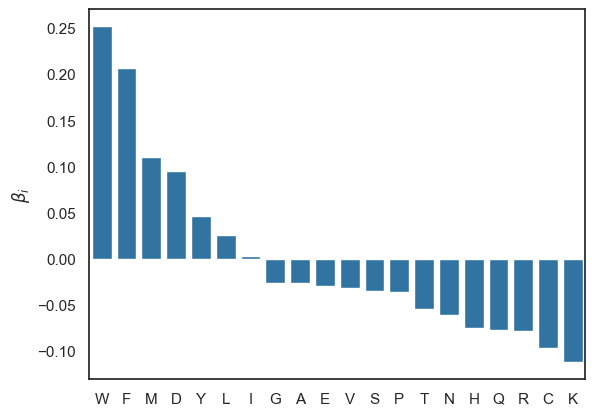

In [4]:
coefs = dict(zip(list(alphabet), regr_single.coef_.flatten()))
coefs = pd.DataFrame({0: coefs}).sort_values(by=0, ascending=False)

sns.barplot(coefs.to_dict()[0])
plt.ylabel(r"$\beta_i$")
plt.show()

In [5]:
y_pred = regr_single.predict(X_aa)
_, y_cont_comp, _, scaler = get_inputs(seqs, y_pred, thresh)
train, val, test, indices = get_stratified_split(X, y_bin, y_cont_comp, as_tensor=True)
(X_train, y_bin_train, y_cont_comp_train) = train
(X_val, y_bin_val, y_cont_comp_val) = val
(X_test, y_bin_test, y_cont_comp_test) = test
# test_idx, val_idx = indices

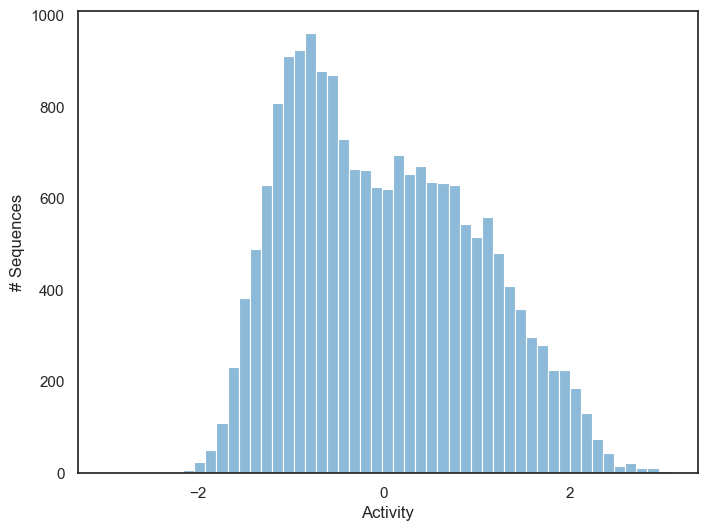

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(y_cont_comp, legend=False, ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')
plt.show()

In [7]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_comp_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_comp_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [8]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model_comp = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3, one_hot=True)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model_comp, train_dataloaders=train_dl, val_dataloaders=val_dl)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.54it/s]val_rmse 1.012466549873352
val_pearsonr 0.009276891127228737
val_spearmanr 0.026040716096758842
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 134/134 [00:01<00:00, 67.32it/s, loss=0.0442, v_num=12]val_rmse 0.171288400888443
val_pearsonr 0.9889192581176758
val_spearmanr 0.9884433746337891
Epoch 1: 100%|██████████| 134/134 [00:01<00:00, 86.89it/s, loss=0.058, v_num=12] val_rmse 0.21070308983325958
val_pearsonr 0.9926846623420715
val_spearmanr 0.9925144910812378
Epoch 2: 100%|██████████| 134/134 [00:01<00:00, 85.88it/s, loss=0.0534, v_num=12]val_rmse 0.12154583632946014
val_pearsonr 0.9949550628662109
val_spearmanr 0.995273768901825
Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 85.72it/s, loss=0.0221, v_num=12]val_rmse 0.14465740323066711
val_pearsonr 0.9966239929199219
val_spearmanr 0.9964852333068848
Epoch 4: 100%|██████████| 134/134 [00:01<00:00, 77.98it/s, loss=0.00972, v_num=12]val_rmse 0.11962256580591202
val_pearsonr 0.9973861575126648
val_spearmanr 0.9975590109825134
Epoch 5: 100%|██████████| 134/134 [00:01<00:00, 82.94it/s, loss=0.0222, v_num=12] val_rmse 0.11885647475719452
val_pearsonr 0.9

In [9]:
model_comp = model_comp.load_from_checkpoint(checkpoint_callback.best_model_path)


In [10]:
# scaler.transform(np.array(thresh).reshape(-1, 1)).item()

In [11]:
def plot_corr(y_test_hat, y_test):
    fig, ax = plt.subplots()#figsize=(12,10))
    ax.scatter(y_test_hat, y_test, alpha=0.5)
    s_corr = spearmanr(y_test_hat, y_test).correlation
    p_corr = pearsonr(y_test_hat, y_test).correlation
    ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Pearson: {p_corr:.3f}\nSpearman: {s_corr:.3f}")
    # ax.set(xlim=(-.2, 3), ylim=(-.2, 3))
    plt.tight_layout()
    # plt.axvline(x=thresh, c='green', ymax=thresh)
    # plt.axhline(y=thresh, c='green', xmax=thresh)
    plt.show()

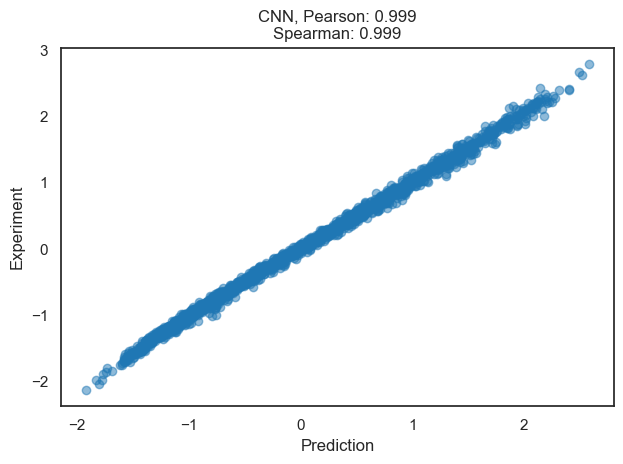

In [12]:

sns.set_style("white")
sns.set_context("notebook")

test_ds = TensorDataset(X_test, y_cont_comp_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model_comp.eval()
X_test, y_test_comp = test_ds[:]
y_test_comp = y_test_comp.reshape(-1)
with torch.no_grad():
    y_test_hat_comp = model_comp(X_test).reshape(-1)
    y_test_hat_comp = y_test_hat_comp.detach().numpy()
    y_test_comp = y_test_comp.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat_comp)
# best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_comp_bin = (y_test_hat_comp > best_thresh).astype(np.int32)

plot_corr(y_test_hat_comp, y_test_comp)


## DeepLIFT

In [13]:
from captum.attr import LayerDeepLift
thresh_nonad = 50000
X_ad = model_comp.model.encode(torch.tensor(X[activity >= thresh]))
X_neg = model_comp.model.encode(torch.tensor(X[activity < thresh_nonad]))
baseline_neg = X_neg.mean(dim=0).unsqueeze(0)

dl = LayerDeepLift(model_comp, model_comp.model.emb, multiply_by_inputs=False)
attr_comp = dl.attribute(X_ad, baseline_neg, attribute_to_layer_input=True)
dx = X_ad - baseline_neg
attr_comp = attr_comp * np.abs(dx)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_13249/670899864.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  attr_comp = attr_comp * np.abs(dx)


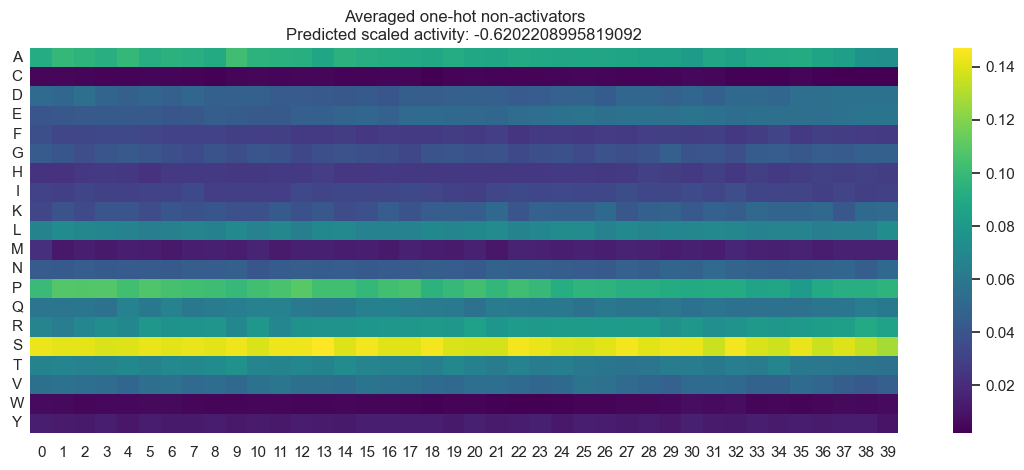

In [14]:
baseline_df = pd.DataFrame(baseline_neg.squeeze()).T
baseline_df.index = list(alphabet)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
ax.set_xticklabels(range(40), ha="center", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
ax.set_title(f"Averaged one-hot non-activators\nPredicted scaled activity: {model_comp(baseline_neg).item()}")
plt.show()

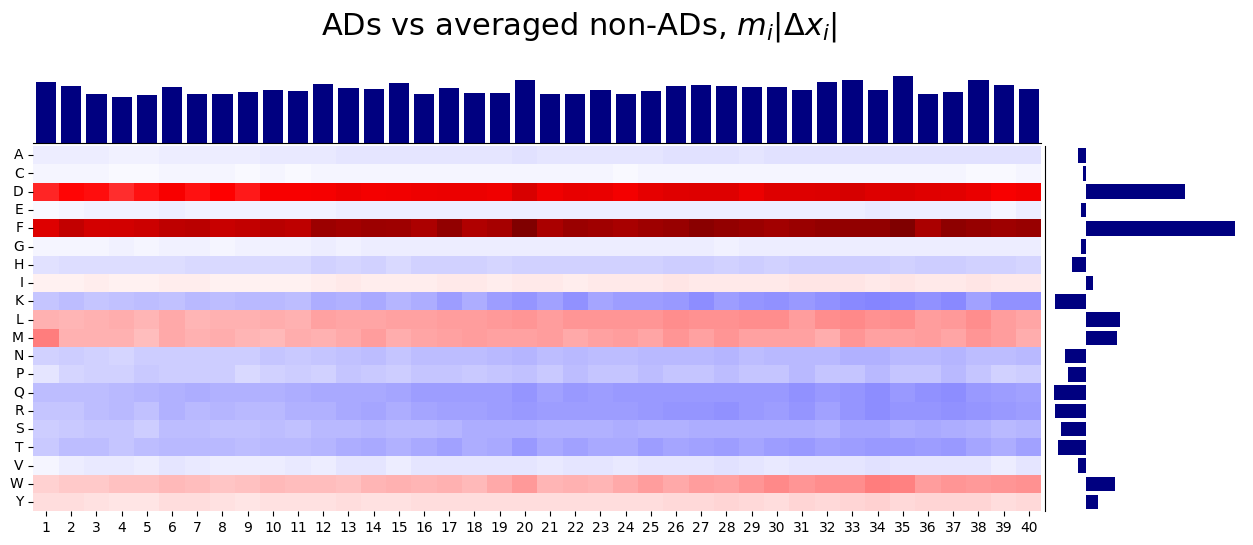

In [15]:
sns.reset_defaults()

def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True).detach().numpy()
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None, cmap="seismic"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap=cmap, center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax
def joint_plot(attr_df, title=""):
    attr_df_melt = (attr_df
                        .rename_axis("AA")
                        .reset_index()
                        .melt(
                            id_vars=['AA'], 
                            var_name='pos', 
                            value_name='val'))

    D = 40
    H = 20
    df_ = attr_df_melt

    g = sns.jointplot(data=df_, x='AA', y='pos', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(
        data=df_['val'].to_numpy().reshape(D, H).T, 
        ax=g.ax_joint, cbar=False, cmap='seismic', 
        center=0)

    g.ax_marg_y.barh(np.arange(0.5, H), df_.groupby(['AA'])['val'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df_.groupby(['pos'])['val'].sum().to_numpy(), color='navy')

    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    g.ax_joint.set_yticks(np.arange(0.5, H))
    g.ax_joint.set_yticklabels(list(alphabet), rotation=0)

    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

    g.fig.set_size_inches(14,5)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    plt.suptitle(title, fontsize=22, y=1.1)
    plt.show()


attr_df = pd.DataFrame(attr_comp.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)
joint_plot(attr_df, "ADs vs averaged non-ADs, $m_{i}|\Delta{x_i}|$")

# Conditional linear regression

$$y = \beta_0 1\{R + K - D - E \leq -3\}\sum{(W, F, Y, L)} + \epsilon$$

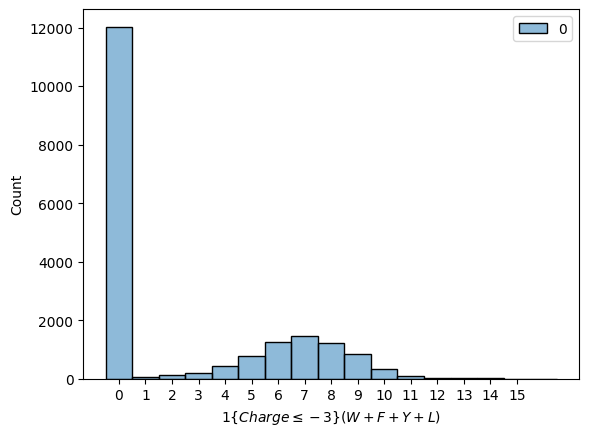

In [16]:
charges = (df["Seq"].str.count("R|K") - df["Seq"].str.count("D|E")).values
wfyl = df["Seq"].str.count("W|F|Y|L").values
charge_indicator = (charges <= -3).astype(int)
x = (charge_indicator * wfyl).reshape(-1, 1)
sns.histplot(x, discrete=True,)
plt.xticks((range(max(x).item())))
plt.xlabel(r"$1\{Charge \leq -3\} (W + F + Y + L) $")
plt.show()

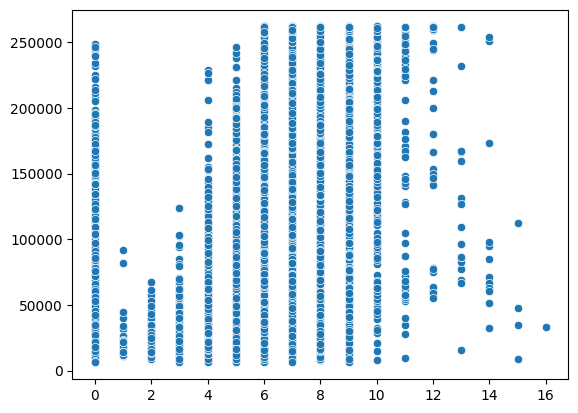

In [17]:
sns.scatterplot(x=x.flatten(), y=activity.flatten())
plt.show()

In [18]:
X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(x, y_cont, stratify=y_bin, train_size=.8)

regr_co = LinearRegression()
regr_co.fit(X_co_train, y_co_train)
print(regr_co.score(X_co_test, y_co_test))
y_pred_co = regr_co.predict(x)

# regr_co.coef_

0.4386239962825822


In [46]:
co_s_r = spearmanr(regr_co.predict(X_co_test).flatten(), y_co_test.flatten()).statistic.item()
co_p_r = pearsonr(regr_co.predict(X_co_test).flatten(), y_co_test.flatten()).statistic.item()

print(f"Conditional WFYL regression: Spearman : {co_s_r}, Pearson: {co_p_r}")
# y_cont - y_pred_co

Conditional WFYL regression: Spearman : 0.5656260576480034, Pearson: 0.662330574163091


In [20]:
_, y_cont_co, _, scaler = get_inputs(seqs, y_pred_co, 1)
train, val, test, indices = get_stratified_split(X, y_bin, y_cont_co, as_tensor=True)
(X_train, y_bin_train, y_cont_co_train) = train
(X_val, y_bin_val, y_cont_co_val) = val
(X_test, y_bin_test, y_cont_co_test) = test

In [21]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_co_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_co_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [22]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model_co = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3, one_hot=True)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model_co, train_dataloaders=train_dl, val_dataloaders=val_dl)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 168.41it/s]val_rmse 1.0956529378890991
val_pearsonr 0.13002757728099823
val_spearmanr 0.10890212655067444
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 134/134 [00:01<00:00, 85.52it/s, loss=0.159, v_num=13]val_rmse 0.4502868354320526
val_pearsonr 0.9134008288383484
val_spearmanr 0.8353167176246643
Epoch 1: 100%|██████████| 134/134 [00:01<00:00, 76.72it/s, loss=0.132, v_num=13]val_rmse 0.3978196978569031
val_pearsonr 0.9304133057594299
val_spearmanr 0.8398942947387695
Epoch 2: 100%|██████████| 134/134 [00:01<00:00, 88.78it/s, loss=0.132, v_num=13]val_rmse 0.3885408043861389
val_pearsonr 0.9340202212333679
val_spearmanr 0.843628466129303
Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 84.61it/s, loss=0.112, v_num=13]val_rmse 0.340096116065979
val_pearsonr 0.9420018792152405
val_spearmanr 0.8460395932197571
Epoch 4: 100%|██████████| 134/134 [00:01<00:00, 89.32it/s, loss=0.112, v_num=13] val_rmse 0.3368891775608063
val_pearsonr 0.9470121264457703
val_spearmanr 0.8473269939422607
Epoch 5: 100%|██████████| 134/134 [00:01<00:00, 85.15it/s, loss=0.114, v_num=13] val_rmse 0.34658992290496826
val_pearsonr 0.94239008426

In [23]:
model_co = model_co.load_from_checkpoint(checkpoint_callback.best_model_path)


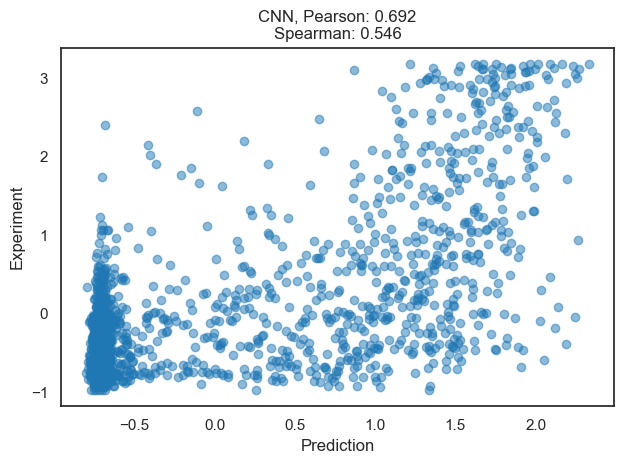

In [24]:
sns.set_style("white")
sns.set_context("notebook")

test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model_co.eval()
X_test, y_test_co = test_ds[:]
y_test_co = y_test_co.reshape(-1)
with torch.no_grad():
    y_test_hat_co = model_co(X_test).reshape(-1)
    y_test_hat_co = y_test_hat_co.detach().numpy()
    y_test_co = y_test_co.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat_co)
# best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat_co > best_thresh).astype(np.int32)

plot_corr(y_test_hat_co, y_test_co)

In [25]:
from captum.attr import LayerDeepLift
thresh_nonad = 50000
X_ad = model_co.model.encode(torch.tensor(X[activity >= thresh]))
X_neg = model_co.model.encode(torch.tensor(X[activity < thresh_nonad]))
baseline_neg = X_neg.mean(dim=0).unsqueeze(0)

dl = LayerDeepLift(model_co, model_co.model.emb, multiply_by_inputs=False)
attr = dl.attribute(X_ad, baseline_neg, attribute_to_layer_input=True)
dx = X_ad - baseline_neg
attr = attr * np.abs(dx)

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_13249/407970152.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  attr = attr * np.abs(dx)


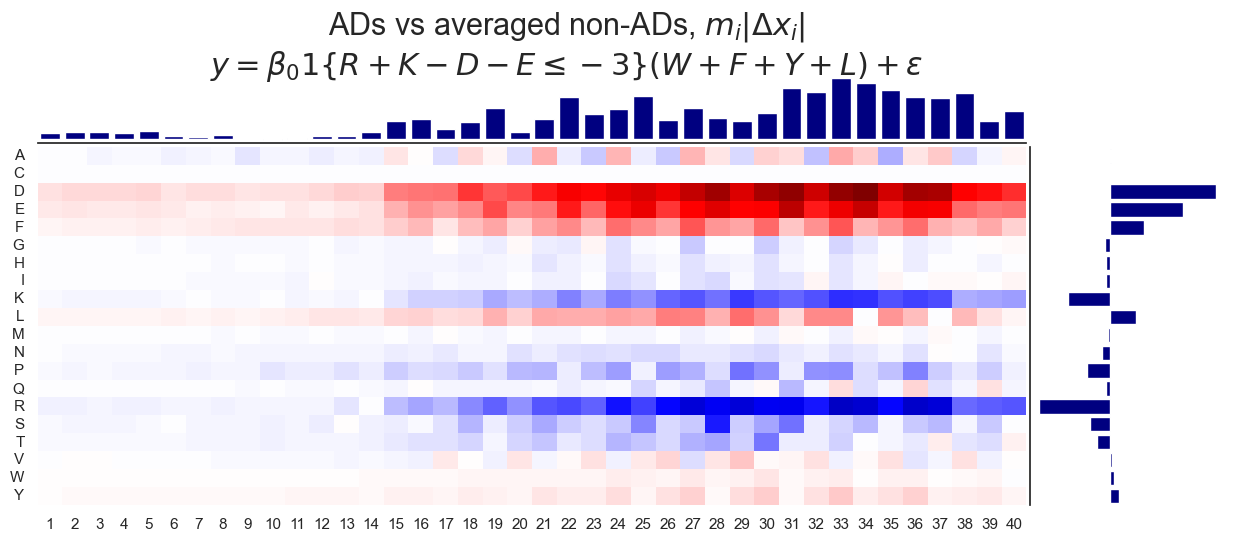

In [26]:
attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)
joint_plot(attr_df, "ADs vs averaged non-ADs, $m_{i}|\Delta{x_i}|$" + "\n" + r"$y = \beta_0 1\{R + K - D - E \leq -3\}(W + F + Y + L) + \epsilon$")

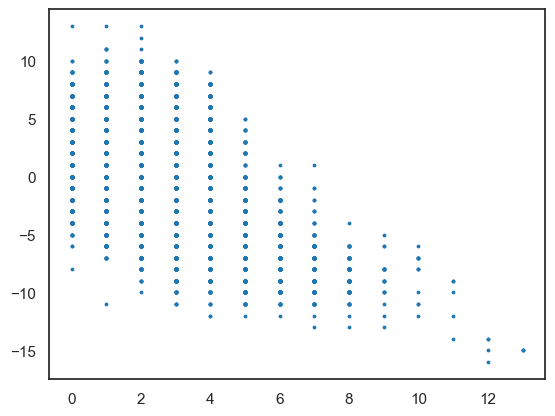

In [27]:
charges
d_cts = df["Seq"].str.count("D").values
plt.scatter(d_cts, charges, s=3)
plt.show()

# OTHER STUFF

In [143]:
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [150]:
X, y_cont, y_bin, scaler = get_inputs(seqs, activity, thresh)

In [ ]:
thresh_nonad = 50_000
thresh = 80_000
X_ad = model.model.encode(torch.tensor(X[activity >= thresh]))
X_neg = model.model.encode(torch.tensor(X[activity < thresh_nonad]))
baseline_neg = X_neg.mean(dim=0).unsqueeze(0)

dl = LayerDeepLift(model, model.model.emb, multiply_by_inputs=False)
attr = dl.attribute(X_ad, baseline_neg, attribute_to_layer_input=True)
dx = X_ad - baseline_neg
attr = attr * np.abs(dx)

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_3706/3896363791.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  attr = attr * np.abs(dx)


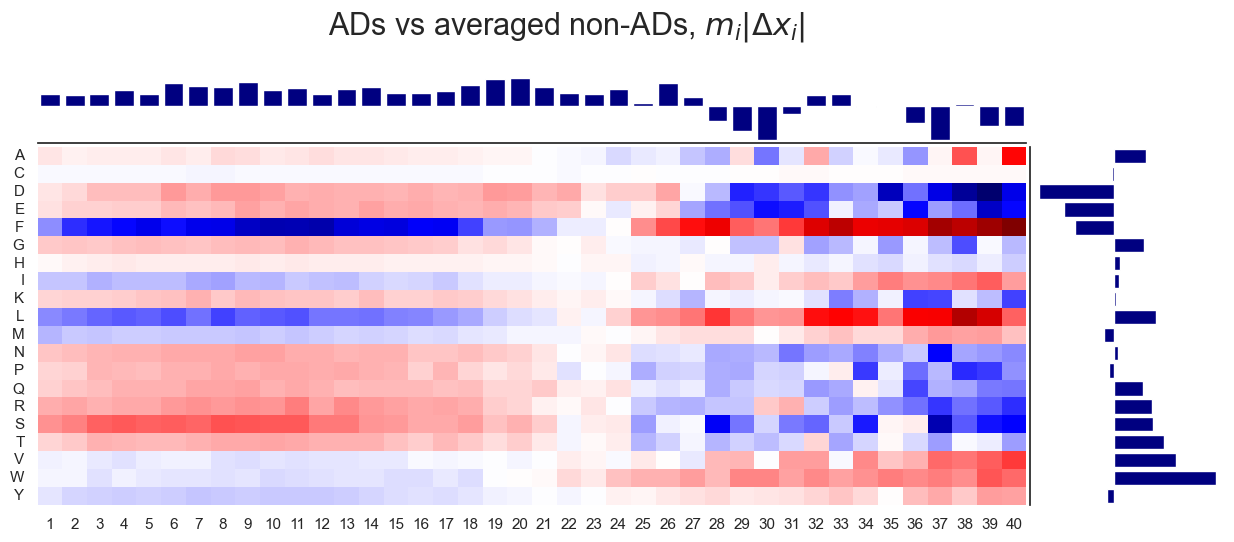

In [152]:
attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)
joint_plot(attr_df, "ADs vs averaged non-ADs, $m_{i}|\Delta{x_i}|$")